# ML Answers

- **Answer Set**: No. 04
- **Full Name**: Mohammad Hosein Nemati
- **Student Code**: `610300185`

---

## Basics

In this section we will done some basic steps:

### Libraries

Before begin, we must import these required libraries:

In [392]:
import numpy as np
import scipy.io as sp
import matplotlib.pyplot as plt

### Dataset

Now we can load our dataset:

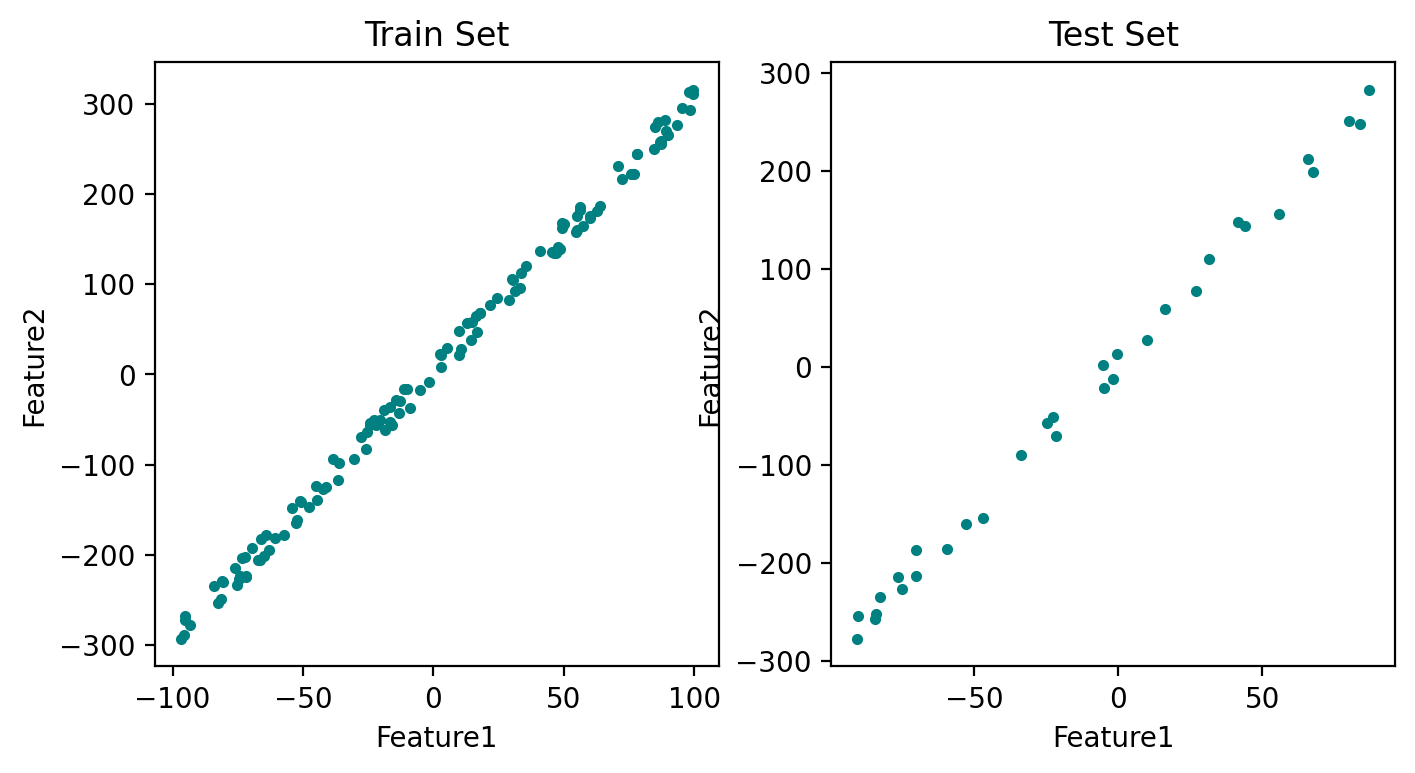

In [393]:
train_set = np.load("../lib/train_set.npy")
test_set = np.load("../lib/test_set.npy")

train_features = train_set[:, :]
test_features = test_set[:, :]

fig = plt.figure(figsize=(8, 4), dpi=200)

ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(train_features.T[0], train_features.T[1], marker=".", c="teal")
ax1.set_title("Train Set")
ax1.set_xlabel("Feature1")
ax1.set_ylabel("Feature2")

ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(test_features.T[0], test_features.T[1], marker=".", c="teal")
ax2.set_title("Test Set")
ax2.set_xlabel("Feature1")
ax2.set_ylabel("Feature2")

plt.show()

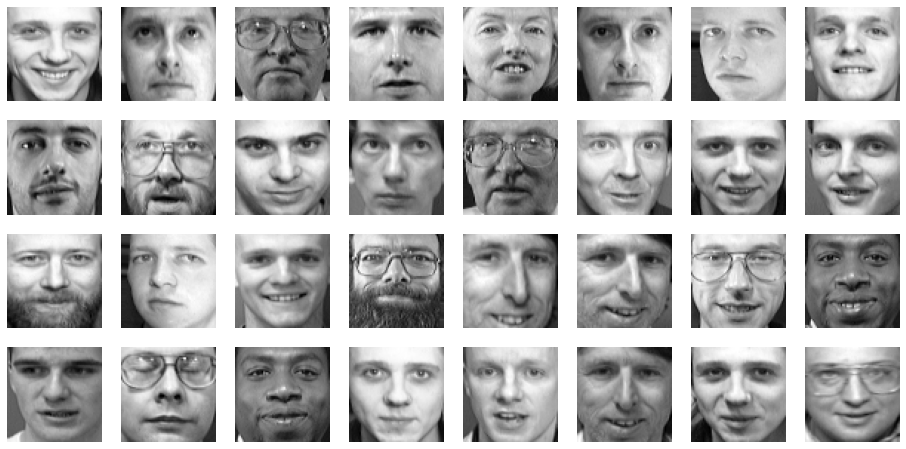

In [394]:
faces_set = sp.loadmat("../lib/faces.mat")["faces"].T

np.random.shuffle(faces_set)

train_faces = faces_set[0:280, :]
test_faces = faces_set[280:-1, :]

faces_images = train_faces.reshape(280, 64, 64)

fig = plt.figure(figsize=(16, 8))

for i in range(8):
    for j in range(4):
        ax = fig.add_subplot(4, 8, (i * 4) + j + 1)
        ax.imshow(faces_images[i * 8 + j].T, cmap="gray")
        ax.axis("off")

plt.show()


### Standardize

Now, we standardize our train, test features:

$$
\begin{aligned}
    & X_{standard} = X - \mu(X)
\end{aligned}
$$

In [395]:
features_mean = np.mean(train_features, axis=0)
train_features = train_features - features_mean
test_features = test_features - features_mean

faces_mean = np.mean(train_faces, axis=0)
train_faces = train_faces - faces_mean
test_faces = test_faces - faces_mean

### Features Function

A useful function, that generates a feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree:

In [396]:
def features_matrix(features, degree):
    features = features.T
    result = []

    for i in range(0, degree + 1):
        for coeffs in polynomial_coefficients(len(features), i, 0):
            terms = [np.power(features[index], coeff) for index, coeff in enumerate(coeffs)]
            result.append(np.prod(terms, axis=0))
    
    return np.array(result).T

def polynomial_coefficients(terms, degree, index):
    result = []

    if index == terms - 1:
        return [[degree]]

    for i in range(degree, -1, -1):
        for coeff in polynomial_coefficients(terms, degree - i, index + 1):
            result.append([i] + coeff)

    return result

---

## Problem (1)

### (0)

First we `Normalize` data records:

$$
\begin{aligned}
    & X = \{
        \begin{bmatrix} 0 \\ -1\end{bmatrix},
        \begin{bmatrix} 1 \\  0\end{bmatrix},
        \begin{bmatrix} 2 \\  1\end{bmatrix},
        \begin{bmatrix} 1 \\  1\end{bmatrix},
        \begin{bmatrix}-1 \\  1\end{bmatrix},
        \begin{bmatrix}-1 \\ -1\end{bmatrix},
        \begin{bmatrix}-1 \\ -1\end{bmatrix}
    \}
    \\
    \\
    & \mu(X) = \frac{(
        \begin{bmatrix} 0 \\ -1\end{bmatrix} +
        \begin{bmatrix} 1 \\  0\end{bmatrix} +
        \begin{bmatrix} 2 \\  1\end{bmatrix} +
        \begin{bmatrix} 1 \\  1\end{bmatrix} +
        \begin{bmatrix}-1 \\  1\end{bmatrix} +
        \begin{bmatrix}-1 \\ -1\end{bmatrix} +
        \begin{bmatrix}-1 \\ -1\end{bmatrix}
    )}{7} = \begin{bmatrix}\frac{1}{7} \\ 0\end{bmatrix}
    \\
    \\
    & SD(X) = \begin{bmatrix}1.12 \\ 0.92\end{bmatrix}
    \\
    \\
    & X_{standard} = \frac{X - \mu(X)}{SD(X)} = \{
        \begin{bmatrix}-0.12 \\ -1.08\end{bmatrix},
        \begin{bmatrix} 0.76 \\  0.  \end{bmatrix},
        \begin{bmatrix} 1.65 \\  1.08\end{bmatrix},
        \begin{bmatrix} 0.76 \\  1.08\end{bmatrix},
        \begin{bmatrix}-1.01 \\  1.08\end{bmatrix},
        \begin{bmatrix}-1.01 \\ -1.08\end{bmatrix},
        \begin{bmatrix}-1.01 \\ -1.08\end{bmatrix}
    \}
\end{aligned}
$$

### (1)

Now we find the `Covariance Matrix` for standardized records ($\Sigma$):

$$
\begin{aligned}
    & \Sigma = \begin{bmatrix}
        Cov(X_0, X_0) & Cov(X_0, X_1) \\
        Cov(X_1, X_0) & Cov(X_1, X_1)
    \end{bmatrix} = \begin{bmatrix}
        1.16 & 0.64 \\
        0.64 & 1.16
    \end{bmatrix}
\end{aligned}
$$

Now we find the `Eigen Vectors` and `Eigen Values` for `Covariance Matrix`:

$$
\begin{aligned}
    & EigenVectors(\Sigma) = \{
        \begin{bmatrix}-0.70 \\  0.70\end{bmatrix},
        \begin{bmatrix} 0.70 \\  0.70\end{bmatrix}
    \}
    \\
    & EigenValues(\Sigma) = \{0.52, 1.80\}
\end{aligned}
$$

The descending order of `Eigen Vectors` based on `Eigen Values` are `Principal Components`:

$$
\begin{aligned}
    & PC_1 = \begin{bmatrix} 0.70 \\  0.70\end{bmatrix}
    \\
    & PC_2 = \begin{bmatrix}-0.70 \\  0.70\end{bmatrix}
\end{aligned}
$$

### (2)

Now we can find the projection of data on `PC1` vector:

$$
\begin{aligned}
    & X \times PC_1 = \{-0.85, 0.53, 1.93, 1.30, 0.04, -1.48, -1.48\}
\end{aligned}
$$

### (3)

Now we can find the real values using projection of data on `PC1` vector:

$$
\begin{aligned}
    & X' = Projections \times PC_1^T = \{
        \begin{bmatrix}-0.60 \\ -0.60\end{bmatrix},
        \begin{bmatrix} 0.38 \\  0.38\end{bmatrix},
        \begin{bmatrix} 1.36 \\  1.36\end{bmatrix},
        \begin{bmatrix} 0.92 \\  0.92\end{bmatrix},
        \begin{bmatrix} 0.03 \\  0.03\end{bmatrix},
        \begin{bmatrix}-1.04 \\ -1.04\end{bmatrix},
        \begin{bmatrix}-1.04 \\ -1.04\end{bmatrix}
    \}
\end{aligned}
$$

### (4)

Now we can plot the records and their projections:

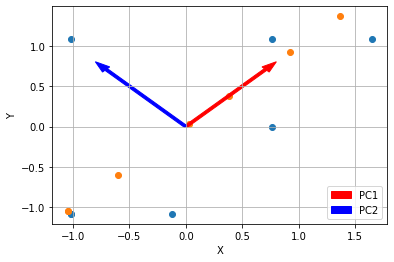

In [397]:
# Define data records
x = np.array([
    [ 0, -1],
    [ 1,  0],
    [ 2,  1],
    [ 1,  1],
    [-1,  1],
    [-1, -1],
    [-1, -1]
])

# Normalize data records
x = (x - np.mean(x, axis=0)) / np.std(x, axis=0)

# Find principal components
cv = np.cov(x.T)
eVal, eVec = np.linalg.eigh(cv)
idx = eVal.argsort()[::-1]
pcx = eVec[:, idx]

# Find projections
y = x @ pcx[:, 0:1]

# Find real values
xp = y @ pcx[:, 0:1].T

# Plot records, prjections, pcx
plt.scatter(x.T[0], x.T[1])
plt.scatter(xp.T[0], xp.T[1])
plt.arrow(0, 0, *pcx[:,0], width=.03, label="PC1", color="red")
plt.arrow(0, 0, *pcx[:,1], width=.03, label="PC2", color="blue")
plt.grid(True, which='both')
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

---

## Problem (2)

### Results

As we can see, **LD1** vector is equals to the `Eigen Vector` related to `Maximum Eigen Value` which is $\begin{bmatrix}1 \\ -0.55\end{bmatrix}$.

---

## Problem (3)

First we will find the **Principal Components** using **Covariance Matrix**:

In [398]:
covariance_matrix = np.cov(train_faces.T)
eigenValues, eigenVectors = np.linalg.eigh(covariance_matrix)
idx = eigenValues.argsort()[::-1]
pcx = eigenVectors[:, idx]

### (1)

Now we will find the projection of data records using $PC_1$ through $PC_{45}$:

RMSE using 45 components: 949.3673380693608


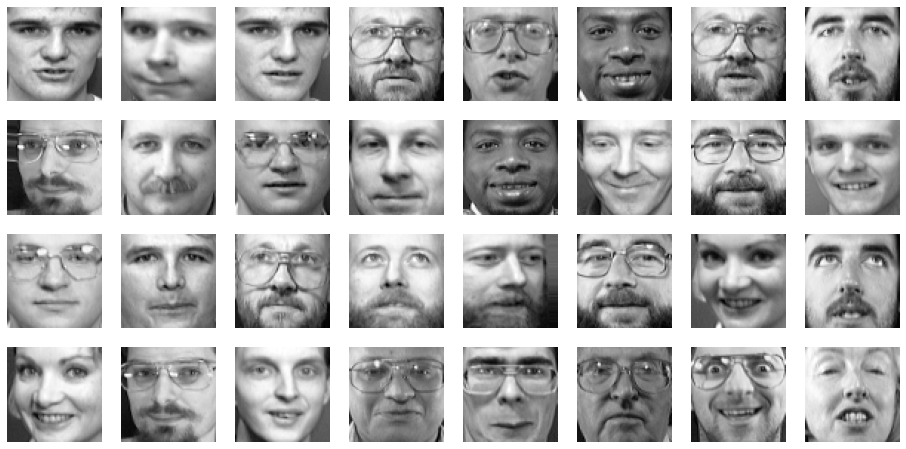

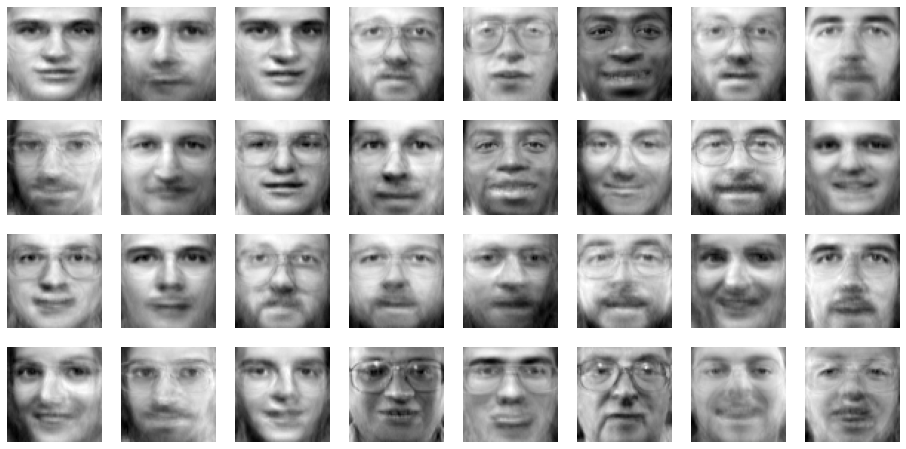

In [399]:
projected_faces = test_faces @ pcx[:, 0:45]
real_faces = projected_faces @ pcx[:, 0:45].T

rmse = np.linalg.norm(real_faces - test_faces) / np.sqrt(len(test_faces))
print(f"RMSE using 45 components: {rmse}")

fig = plt.figure(figsize=(16, 8))
for i in range(8):
    for j in range(4):
        ax = fig.add_subplot(4, 8, (i * 4) + j + 1)
        ax.imshow((test_faces[i * 8 + j] + faces_mean).reshape(64,64).T, cmap="gray")
        ax.axis("off")
plt.show()


fig = plt.figure(figsize=(16, 8))
for i in range(8):
    for j in range(4):
        ax = fig.add_subplot(4, 8, (i * 4) + j + 1)
        ax.imshow((real_faces[i * 8 + j] + faces_mean).reshape(64,64).T, cmap="gray")
        ax.axis("off")
plt.show()

### (2)

Now we will find the best number of principal components, needed for a good fit:

RMSE using 280 components: 661.1361745340502


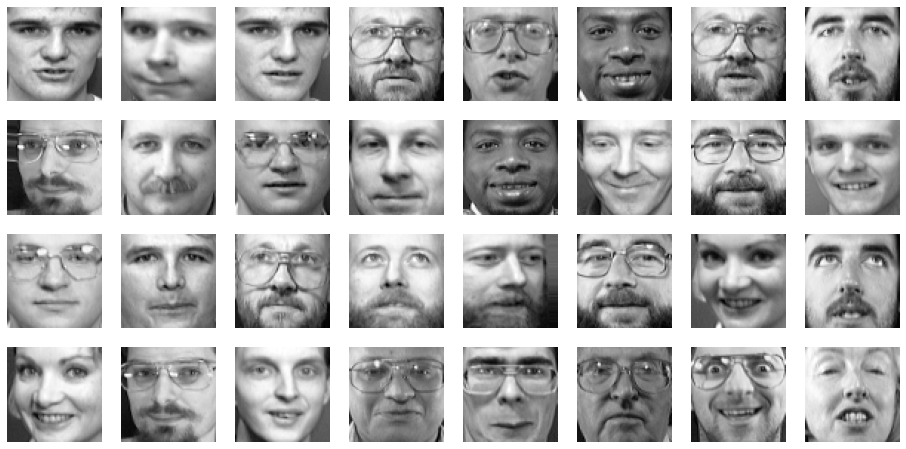

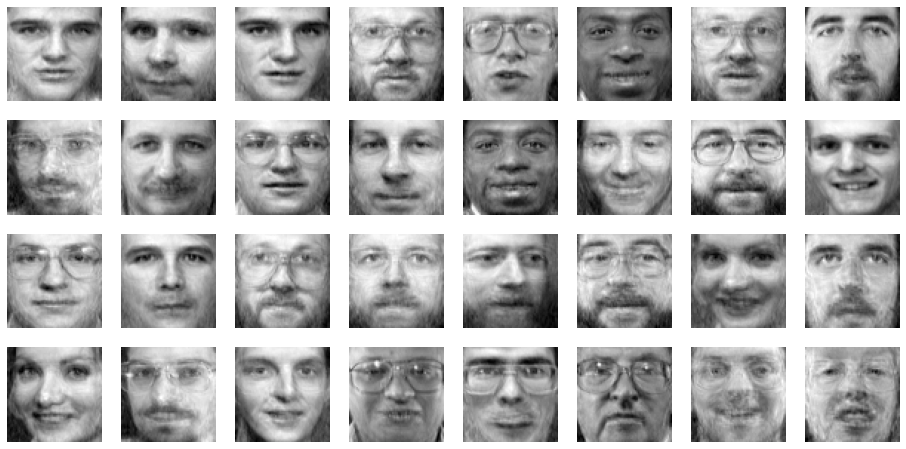

In [400]:
def find_best_number_of_components():
    for i in range(1, 400):
        projected_faces = train_faces @ pcx[:, 0:i*10]
        real_faces = projected_faces @ pcx[:, 0:i*10].T
        rmse = np.linalg.norm(real_faces - train_faces) / np.sqrt(len(train_faces))
        if rmse < 1:
            return i*10
    return 4000

best = find_best_number_of_components()
projected_faces = test_faces @ pcx[:, 0:best]
real_faces = projected_faces @ pcx[:, 0:best].T
rmse = np.linalg.norm(real_faces - test_faces) / np.sqrt(len(test_faces))
print(f"RMSE using {best} components: {rmse}")

fig = plt.figure(figsize=(16, 8))
for i in range(8):
    for j in range(4):
        ax = fig.add_subplot(4, 8, (i * 4) + j + 1)
        ax.imshow((test_faces[i * 8 + j] + faces_mean).reshape(64,64).T, cmap="gray")
        ax.axis("off")
plt.show()


fig = plt.figure(figsize=(16, 8))
for i in range(8):
    for j in range(4):
        ax = fig.add_subplot(4, 8, (i * 4) + j + 1)
        ax.imshow((real_faces[i * 8 + j] + faces_mean).reshape(64,64).T, cmap="gray")
        ax.axis("off")
plt.show()

### Results

As we can see, the `first best` number of components is `280` with `RMSE` for `train set` less than `1`.

---

### Results

As we can see, **LD1** vector is equals to the `Eigen Vector` related to `Maximum Eigen Value` which is $\begin{bmatrix}1 \\ -0.55\end{bmatrix}$.

---

## Problem (4)

### Results

As we can see, **LD1** vector is equals to the `Eigen Vector` related to `Maximum Eigen Value` which is $\begin{bmatrix}1 \\ -0.55\end{bmatrix}$.

---